In [1]:
import requests
import warnings
import string
import joblib
import requests
import multiprocessing
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer
from transformers import BertModel
from torch.nn import functional as F
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from xgboost import XGBClassifier
from abc import ABCMeta, abstractmethod
from pandas.core.common import flatten


warnings.filterwarnings("ignore")

In [3]:
def load_tweets(tweets_file="../data/preprocessed_tweet_20201619.csv", 
                from_date="2017-01-01", 
                to_date="2020-06-01", 
                count=10):
    """
    Parameters: 
        tweet_file: directory
        from_date: str
        to_date: str
        count: int (remove the rows which sentence length are less than certain integer)
    """
    cols = ["date", "time", "username", "tweet", "clean_tweet", "hashtags", 
            "likes_count", "replies_count", "retweets_count", "slang_count"]
    df = pd.read_csv(tweets_file, usecols=cols)
    print("# of total tweets: {}".format(df.shape[0]))
    df.sort_values(by="date", ascending=True, inplace=True)
    df.set_index('date', inplace=True)
    df = df.loc[from_date:to_date]
    df.reset_index(drop=False, inplace=True)
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset="tweet", inplace=True)
    df.drop_duplicates(subset="clean_tweet", inplace=True)
    df = df[df.clean_tweet.str.count('\s+').gt(count)]
    print("There are {} tweets we get.".format(df.shape[0]))
    return df

In [4]:
tweets_zero_shot_df = joblib.load("../data/tweets_zero_shot_df.gzip")
tweets_zero_shot_df.head()

,date,clean_tweet,forex,finance,politics
0,2017-01-01,"Happy New Year, everyone! Like atUser just tol...",0.303849,0.173604,-0.088495
5,2017-01-01,trading forex binaryoptions China steps up scr...,0.096081,0.271760,0.079600
6,2017-01-01,Forex Forum - url replies to: Best Forex Sig...,0.400650,0.093737,-0.008885
7,2017-01-01,Forex Forum - goosebone replies to: Let is Tr...,0.171296,0.102459,-0.000891
8,2017-01-01,Learning MQL4: must-do or just for fun? via /r...,0.256183,0.200302,0.101552


In [5]:
tweets_vectors_df = joblib.load("../data/tweets_vectors_df.gzip")
tweets_vectors_df.head()

,date,clean_tweet,tweet_vector
0,2017-01-01,"Happy New Year, everyone! Like atUser just tol...","[[-0.79348445, -0.4987802, -0.95154035, 0.6900..."
5,2017-01-01,trading forex binaryoptions China steps up scr...,"[[-0.7339663, -0.487271, -0.8836157, 0.6065527..."
6,2017-01-01,Forex Forum - url replies to: Best Forex Sig...,"[[-0.67428637, -0.44596073, -0.8535168, 0.4270..."
7,2017-01-01,Forex Forum - goosebone replies to: Let is Tr...,"[[-0.67091227, -0.4024933, -0.62869585, 0.3217..."
8,2017-01-01,Learning MQL4: must-do or just for fun? via /r...,"[[-0.70847034, -0.5142414, -0.9100832, 0.54885..."


In [6]:
df_original = load_tweets(from_date="2017-01-01", to_date="2020-06-17")
df_original.head()

# of total tweets: 1297358
There are 258865 tweets we get.


,date,time,username,tweet,replies_count,retweets_count,likes_count,hashtags,clean_tweet,slang_count
0,2017-01-01,0 days 07:15:16.000000000,skweird,"Happy New Year, everyone! Like @FuadXIV just t...",0,2,2,[],"Happy New Year, everyone! Like atUser just tol...",0
5,2017-01-01,0 days 07:22:57.000000000,forextradeclub,#trading #forex #binaryoptions China steps up ...,0,0,0,"['#trading', '#forex', '#binaryoptions']",trading forex binaryoptions China steps up scr...,0
6,2017-01-01,0 days 07:11:17.000000000,agustinaboshard,Forex Forum - http://wiki.online replies to...,0,0,0,[],Forex Forum - url replies to: Best Forex Sig...,0
7,2017-01-01,0 days 07:11:16.000000000,agustinaboshard,Forex Forum - goosebone replies to: Let's Tra...,0,0,0,[],Forex Forum - goosebone replies to: Let is Tr...,0
8,2017-01-01,0 days 07:41:09.000000000,fmr_reviews,Learning MQL4: must-do or just for fun? via /r...,0,0,0,"['#forex', '#markets']",Learning MQL4: must-do or just for fun? via /r...,0


In [7]:
df_temp = pd.concat(
    [df_original.date, df_original.username, df_original.tweet, df_original.clean_tweet, 
     df_original.replies_count, df_original.retweets_count, df_original.likes_count, df_original.slang_count, 
     tweets_vectors_df.tweet_vector, tweets_zero_shot_df.forex, tweets_zero_shot_df.finance, tweets_zero_shot_df.politics
     ], axis=1)

In [8]:
df_temp.head()

,date,username,tweet,clean_tweet,replies_count,retweets_count,likes_count,slang_count,tweet_vector,forex,finance,politics
0,2017-01-01,skweird,"Happy New Year, everyone! Like @FuadXIV just t...","Happy New Year, everyone! Like atUser just tol...",0.0,2.0,2.0,0.0,"[[-0.79348445, -0.4987802, -0.95154035, 0.6900...",0.303849,0.173604,-0.088495
5,2017-01-01,forextradeclub,#trading #forex #binaryoptions China steps up ...,trading forex binaryoptions China steps up scr...,0.0,0.0,0.0,0.0,"[[-0.7339663, -0.487271, -0.8836157, 0.6065527...",0.096081,0.271760,0.079600
6,2017-01-01,agustinaboshard,Forex Forum - http://wiki.online replies to...,Forex Forum - url replies to: Best Forex Sig...,0.0,0.0,0.0,0.0,"[[-0.67428637, -0.44596073, -0.8535168, 0.4270...",0.400650,0.093737,-0.008885
7,2017-01-01,agustinaboshard,Forex Forum - goosebone replies to: Let's Tra...,Forex Forum - goosebone replies to: Let is Tr...,0.0,0.0,0.0,0.0,"[[-0.67091227, -0.4024933, -0.62869585, 0.3217...",0.171296,0.102459,-0.000891
8,2017-01-01,fmr_reviews,Learning MQL4: must-do or just for fun? via /r...,Learning MQL4: must-do or just for fun? via /r...,0.0,0.0,0.0,0.0,"[[-0.70847034, -0.5142414, -0.9100832, 0.54885...",0.256183,0.200302,0.101552


In [9]:
df_top10 = df_final.sort_values(['date','forex'], ascending=False).groupby('date').head(10)

In [10]:
df_top10.head()

,date,username,tweet,clean_tweet,replies_count,retweets_count,likes_count,slang_count,tweet_vector,forex,finance,politics
0,2020-06-16,pafxss,FOREX SIGNALS | GBPCAD📡\nSIGN UP NOW!\n👉🏼 http...,FOREX SIGNALS | GBPCAD\nSIGN UP NOW!\n url\nfo...,0,0,0,0,"[[-0.81583554, -0.52500117, -0.7443981, 0.5793...",0.506940,0.190806,0.055904
1,2020-06-16,harshba79051454,SELL #EURJPY ENTRY 121.80 TP 121.30 SL 122.15\...,SELL EURJPY ENTRY 121.80 TP 121.30 SL 122.15\n...,0,0,1,0,"[[-0.83956385, -0.43929824, -0.80420935, 0.717...",0.478897,0.237306,0.060813
2,2020-06-16,amywalshfx,#NZDUSD Signal Live: \n https://wa.me/91830510...,NZDUSD Signal Live: \n url\n\nforex forexsigna...,0,0,2,0,"[[-0.7074298, -0.389989, -0.56572807, 0.537667...",0.468882,0.143562,0.058640
3,2020-06-16,pafxss,FOREX SIGNALS | AUD/CAD👨‍🏫🔥✅📡\nSIGN UP NOW!\n👉...,FOREX SIGNALS | AUD/CAD\nSIGN UP NOW!\n url\nf...,0,0,1,0,"[[-0.7487351, -0.43620852, -0.71853733, 0.4749...",0.443357,0.150576,0.063364
4,2020-06-16,cyprosoftware,NZDUSD Finally Taking a Turn….BEARISH Potentia...,NZDUSD Finally Taking a Turn.BEARISH Potential...,0,0,0,0,"[[-0.7172494, -0.4675475, -0.89836675, 0.60709...",0.417108,0.308723,0.095624


In [11]:
df_final = df_top10.reset_index()
joblib.dump(df_final, "../data/df_final_v2.gzip", compress=3)

['../data/df_final_v2.gzip']

In [13]:
df_final = joblib.load("../data/df_final_v2.gzip")
df_final = df_final.iloc[:, 1:]
df_final.head()

,date,username,tweet,clean_tweet,replies_count,retweets_count,likes_count,slang_count,tweet_vector,forex,finance,politics
0,2020-06-16,pafxss,FOREX SIGNALS | GBPCAD📡\nSIGN UP NOW!\n👉🏼 http...,FOREX SIGNALS | GBPCAD\nSIGN UP NOW!\n url\nfo...,0,0,0,0,"[[-0.81583554, -0.52500117, -0.7443981, 0.5793...",0.506940,0.190806,0.055904
1,2020-06-16,harshba79051454,SELL #EURJPY ENTRY 121.80 TP 121.30 SL 122.15\...,SELL EURJPY ENTRY 121.80 TP 121.30 SL 122.15\n...,0,0,1,0,"[[-0.83956385, -0.43929824, -0.80420935, 0.717...",0.478897,0.237306,0.060813
2,2020-06-16,amywalshfx,#NZDUSD Signal Live: \n https://wa.me/91830510...,NZDUSD Signal Live: \n url\n\nforex forexsigna...,0,0,2,0,"[[-0.7074298, -0.389989, -0.56572807, 0.537667...",0.468882,0.143562,0.058640
3,2020-06-16,pafxss,FOREX SIGNALS | AUD/CAD👨‍🏫🔥✅📡\nSIGN UP NOW!\n👉...,FOREX SIGNALS | AUD/CAD\nSIGN UP NOW!\n url\nf...,0,0,1,0,"[[-0.7487351, -0.43620852, -0.71853733, 0.4749...",0.443357,0.150576,0.063364
4,2020-06-16,cyprosoftware,NZDUSD Finally Taking a Turn….BEARISH Potentia...,NZDUSD Finally Taking a Turn.BEARISH Potential...,0,0,0,0,"[[-0.7172494, -0.4675475, -0.89836675, 0.60709...",0.417108,0.308723,0.095624


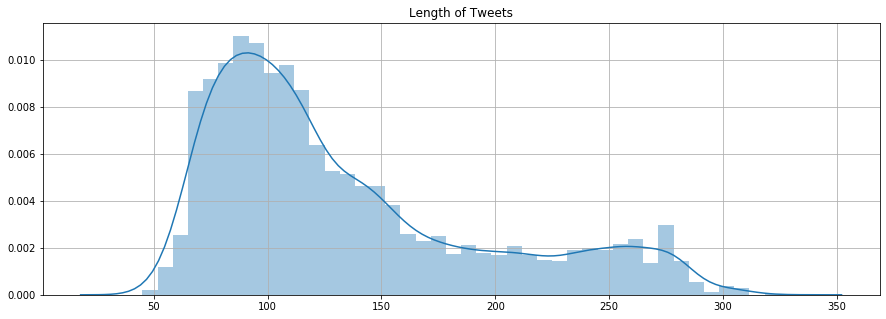

In [14]:
plt.figure(figsize=(15, 5))
ax = sns.distplot(df_final["clean_tweet"].map(len))
plt.xlabel(None)
plt.title("Length of Tweets")
plt.grid()
plt.show()

In [17]:
df_agg = df_final.groupby('date')['clean_tweet'].apply(list)
df_agg = pd.DataFrame(df_agg)
df_agg.reset_index(drop=False, inplace=True)
df_agg.columns = ["date", "aggregated_tweets"]
df_agg["date"] = pd.to_datetime(df_agg["date"])
df_agg.head()

,date,aggregated_tweets
0,2017-01-01,[Forex Signals APP| url fx forex fb forexsigna...
1,2017-01-02,[Zhou Xiaochuan: Life for dogs !! - Sign the P...
2,2017-01-03,[New Glaeser paper on real estate bubbles sugg...
3,2017-01-04,[Zhou Xiaochuan: Life for dogs !! - Sign the P...
4,2017-01-05,[Zhou Xiaochuan: Life for dogs !! - Sign the P...


In [18]:
df_agg.iloc[1]["aggregated_tweets"]

['Zhou Xiaochuan: Life for dogs !! - Sign the Petition!  url via atUser',
 'Zhou Xiaochuan: Life for dogs !! - Sign the Petition!  url via atUser',
 'Zhou Xiaochuan: Life for dogs !! - Sign the Petition!  url via atUser',
 'Zhou Xiaochuan: Life for dogs !! - Sign the Petition!  url via atUser',
 'Zhou Xiaochuan: Life for dogs !! - Sign the Petition!  url via atUser']

In [87]:
df_final.drop_duplicates(subset="tweet", inplace=True)
df_agg = df_final.groupby('date')['clean_tweet'].agg(sum)
# df_agg = df_final.groupby('date')['clean_tweet'].apply(list)
df_agg = pd.DataFrame(df_agg)
df_agg.reset_index(drop=False, inplace=True)
df_agg.columns = ["date", "aggregated_tweets"]
df_agg["date"] = pd.to_datetime(df_agg["date"])
df_agg.head()

,date,aggregated_tweets
0,2017-01-01,Forex Signals APP| url fx forex fb forexsignal...
1,2017-01-02,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...
2,2017-01-03,New Glaeser paper on real estate bubbles sugge...
3,2017-01-04,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...
4,2017-01-05,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...


In [88]:
fx = pd.read_csv("../data/Currency_Data_EURUSD.csv", index_col=False)
fx.columns = ["currecny", "date", "Open", "High", "Low", "Close"]
fx["date"] = pd.to_datetime(fx["date"])
fx.sort_values(by='date', inplace=True)
fx.reset_index(drop=True, inplace=True)
fx["label"] = fx["Close"].diff(periods=1)
fx.dropna(inplace=True)
fx.drop("currecny", axis=1, inplace=True)
fx["label"] = fx["label"].map(lambda x: 1 if float(x)>=0 else 0)
fx.head()

,date,Open,High,Low,Close,label
1,2007-01-10,1.4232,1.4238,1.4140,1.4155,1
2,2007-01-11,1.4488,1.4488,1.4405,1.4425,1
3,2007-02-08,1.3669,1.3705,1.3652,1.3704,0
4,2007-02-11,1.4425,1.4528,1.4416,1.4504,1
5,2007-03-08,1.3703,1.3819,1.3684,1.3774,0


In [89]:
tweets_and_fx = pd.merge(df_agg, fx, on=["date"])
tweets_and_fx.set_index('date', inplace=True)
tweets_and_fx.head()

,aggregated_tweets,Open,High,Low,Close,label
date,,,,,,
2017-01-02,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,1.0784,1.0810,1.0737,1.0753,1
2017-01-03,New Glaeser paper on real estate bubbles sugge...,1.0607,1.0611,1.0514,1.0563,0
2017-01-06,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,1.1237,1.1257,1.1202,1.1210,1
2017-01-09,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,1.1881,1.1980,1.1850,1.1860,1
2017-01-13,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,1.0649,1.0673,1.0596,1.0643,0


In [90]:
train = tweets_and_fx.loc[:"2019-02-24"]
test = tweets_and_fx.loc["2019-02-25":]

In [91]:
# Reference from https://www.kaggle.com/mohanamurali/bgow-tf-idf-lr-w2v-lgb-bayesopt
class TfidfWord2VecVectorizer:
    def __init__(self):
        # Load in pretrained word vectors from https://github.com/Kyubyong/wordvectors
        print("Loading in word vectors...")
        self.w2v = KeyedVectors.load_word2vec_format(
            r"F:\embedding_file\GoogleNews-vectors-negative300.bin", binary=True)
        self.word2vec = {w: vec for w, vec in zip(self.w2v.index2word, self.w2v.vectors)}
        self.word2weight = None
        self.dim = self.w2v.wv.vector_size
        print("Finished loading in word vectors.")
        
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [95]:
def performance(model, x_test, y_test):
    print("test accuracy: ", round(model.score(x_test, y_test), 4))
    print("f-beta score: ", round(f1_score(y_test, model.predict(x_test)), 4))
    print("roc auc score: ", round(roc_auc_score(y_test, model.predict(x_test)), 4))
    print("matthews corrcoef: ", round(matthews_corrcoef(y_test, model.predict(x_test)), 4))
    print("confusion matrix: \n", confusion_matrix(y_test, model.predict(x_test)))

In [92]:
print("Using TfidfWord2VecVectorizer.\n")
vectorizer = TfidfWord2VecVectorizer()
vectorizer.fit(train["aggregated_tweets"])
x_train = vectorizer.transform(train.aggregated_tweets)
y_train = train.label
x_test = vectorizer.transform(test.aggregated_tweets)
y_test = test.label
print("\n# of train data: {}\n# of features: {}\n".format(x_train.shape[0], x_train.shape[1]))
print("\n# of test data: {}\n# of features: {}\n".format(x_test.shape[0], x_test.shape[1]))
print("Training data: \n", x_train)

Using TfidfWord2VecVectorizer.

Loading in word vectors...
Finished loading in word vectors.

# of train data: 482
# of features: 300


# of test data: 260
# of features: 300

Training data: 
 [[-0.18784142  0.10578568  0.04770598 ... -0.00344589 -0.13195562
   0.14331032]
 [-0.1874183   0.10545707  0.03528882 ... -0.0066339  -0.12598178
   0.15108693]
 [-0.1748083   0.10517734  0.03249717 ... -0.00550679 -0.1317203
   0.15159799]
 ...
 [-0.163742    0.09733266  0.02321881 ...  0.00962722 -0.1101889
   0.15351744]
 [-0.15563968  0.10581069  0.01202839 ... -0.00212094 -0.10369589
   0.14366658]
 [-0.18039922  0.11429542  0.00549251 ... -0.0046994  -0.10674055
   0.15465508]]


In [98]:
xgb = XGBClassifier(
    n_jobs=multiprocessing.cpu_count(), 
    random_state=17, 
    verbosity=1)

params = { 
    'n_estimators': [100, 200, 300, 400], 
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 15, 20]
}

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=17)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=6, 
    cv=skf.split(x_train, y_train), 
    verbose=2, 
    random_state=17)
random_search.fit(x_train, y_train)
xgb = random_search.best_estimator_
performance(xgb, x_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    7.2s finished


test accuracy:  0.5269
f-beta score:  0.481
roc auc score:  0.5235
matthews corrcoef:  0.0471
confusion matrix: 
 [[80 58]
 [65 57]]


In [100]:
rfc = RandomForestClassifier(
    random_state=17, 
    n_jobs=multiprocessing.cpu_count())

params = { 
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 4, 5]
}

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=17)

random_search = RandomizedSearchCV(
    rfc, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=6, 
    cv=skf.split(x_train, y_train), 
    verbose=1, 
    random_state=17)
random_search.fit(x_train, y_train)
rfc = random_search.best_estimator_
performance(rfc, x_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    1.9s finished


test accuracy:  0.5308
f-beta score:  0.4455
roc auc score:  0.5233
matthews corrcoef:  0.048
confusion matrix: 
 [[89 49]
 [73 49]]


In [104]:
class Strategy(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        raise NotImplementedError("Should implement generate_signals()!")
        
class Portfolio(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        raise NotImplementedError("Should implement backtest_portfolio()!")

        
class RandomForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = np.sign(np.random.randn(len(signals)))
        return signals
    
class MarketIntradayPortfolio(Portfolio):
    
    def __init__(self, symbol, bars, signals, initial_capital=100000, trading_sum=100):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.trading_sum = float(trading_sum)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.symbol] = self.trading_sum*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
        
        
        portfolio['price_diff'] = self.bars['Close']-self.bars['Open']
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']

        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio
    
class MachineLearningForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars, pred):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self, pred):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = pred
        return signals
    
def model_backtesting(model, x_test, test, model_name, currency_name, initial_capital=100000, trading_sum=10000):
    pred = model.predict(x_test)
    pred = pred.tolist()
    pred = [1 if p == 1 else -1 for p in pred]
    
    test['Close'] = test['Close'].shift(-1)
    rfs = MachineLearningForecastingStrategy(currency_name, test, pred)
    signals = rfs.generate_signals(pred)
    portfolio = MarketIntradayPortfolio(currency_name, test, signals, initial_capital, trading_sum)
    returns = portfolio.backtest_portfolio()
    
    returns['signal'] = signals
    our_pct_growth = returns['total'].pct_change().cumsum()
    benchmark_ptc_growth = test['Close'].pct_change().cumsum()
    
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 1, 1)
    plt.plot(returns['total'])
    plt.title("Total Return on {} using {}".format(currency_name, model_name))
    plt.grid()
    
    plt.subplot(2, 1, 2)
    plt.plot(our_pct_growth, label = 'ML long/short strategy', linewidth=2)
    plt.plot(benchmark_ptc_growth, linestyle = '--', label = 'Buy and hold strategy', linewidth=2)
    plt.title("ML Strategy V.S. Buy and Hold Strategy\nModel: {}\nCurrecy: {}".format(model_name, currency_name))
    plt.legend()
    plt.grid()
    plt.show()

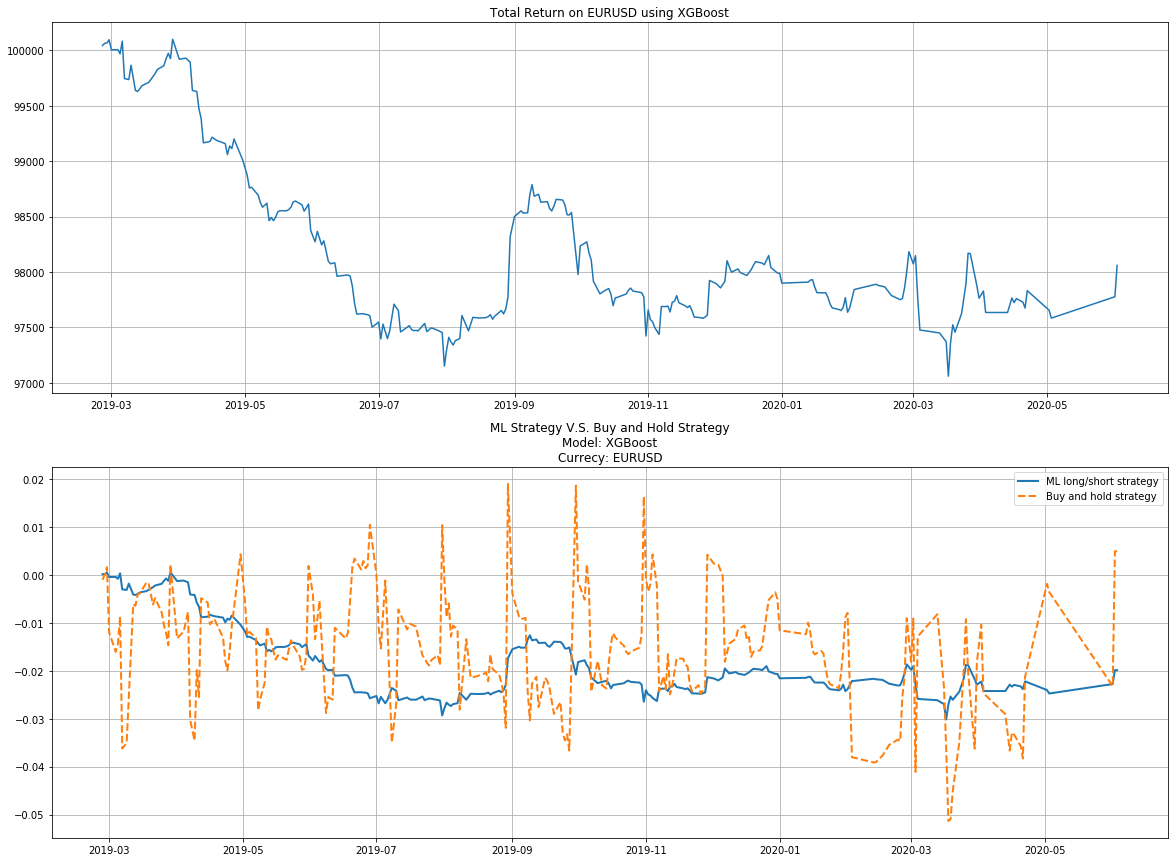

In [105]:
model_backtesting(xgb, x_test, test, "XGBoost", "EURUSD")

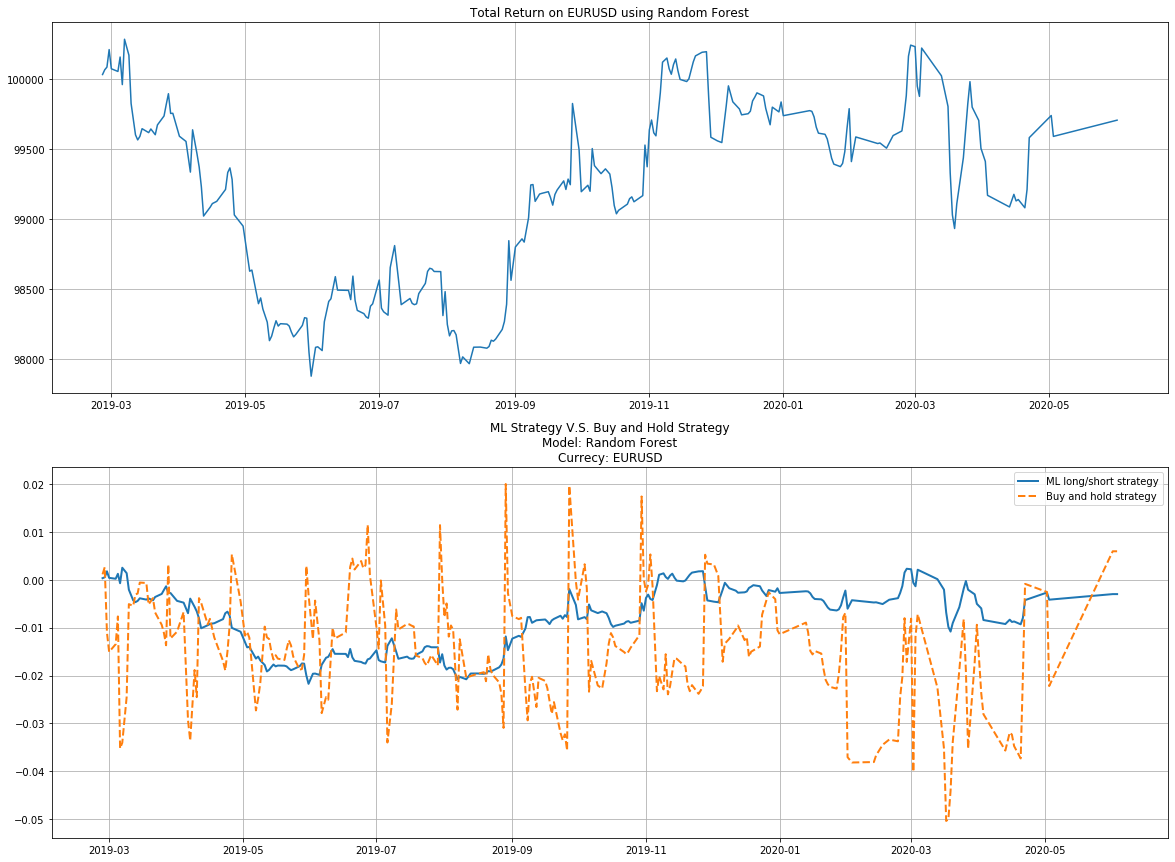

In [106]:
model_backtesting(rfc, x_test, test, "Random Forest", "EURUSD")